In [1]:
# ------------------------------
# RQ1(a). ALIGNED ROLEPLAY vs. MISALIGNED ROLEPLAY

# This code is used to answer RQ1(a): To what extent does the alignment of partisanship between LLMs and the audience enhance the persuasiveness of role-playing LLMs compared to a misaligned LLM?
# ------------------------------

# Import libraries
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter(action='ignore', category=ConvergenceWarning)

# Read in cleaned data
df = pd.read_csv('../data/final_dataset.csv')

# Reshape the dataframe 
reshaped_df = df.melt(
    id_vars='prolific_ID', 
    value_vars=['dv_response_mean_vax', 'dv_response_mean_dep', 'dv_response_mean_elec'], 
    var_name='response_type', 
    value_name='dv_response_mean'
)

# Map additional data columns to the reshaped dataframe
reshaped_df['party'] = reshaped_df['prolific_ID'].map(df.set_index('prolific_ID')['party'])
reshaped_df['aligned'] = reshaped_df['prolific_ID'].map(df.set_index('prolific_ID')['aligned'])
reshaped_df['condition'] = reshaped_df['prolific_ID'].map(df.set_index('prolific_ID')['condition'])


# Create new dataframes for each issue stance
df_for = reshaped_df.query("condition in ['repub_for', 'dem_for']")
df_against = reshaped_df.query("condition in ['repub_against', 'dem_against']")

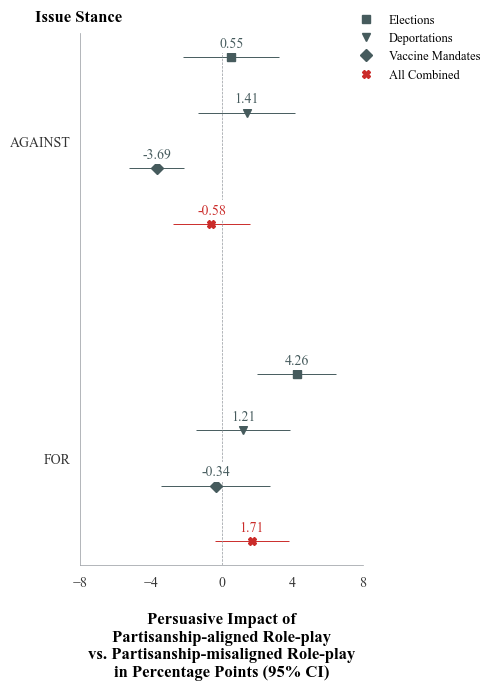

In [2]:
# GENERATE PLOT
# Global Constants
TITLES = ['Combined For', 'Vax For', 'Dep For', 'Elec For', 'Combined Against', 'Vax Against', 'Dep Against', 'Elec Against']
COLOR_MAP = ['#CB2C2A','#465B5D', '#465B5D', '#465B5D', '#CB2C2A', '#465B5D', '#465B5D', '#465B5D']
MARKERS = ['X','D', 'v', 's'] * 2
ISSUE_MARKER_DICT = {'Elections': 's', 'Deportations': 'v', 'Vaccine Mandates': 'D', 'All Combined': 'X'}
ISSUE_COLOR_DICT = {'All Combined': '#CB2C2A', 'Vaccine Mandates': '#465B5D', 'Deportations': '#465B5D', 'Elections': '#465B5D'}

# Helper Functions
def fit_model(formula, data, group_column):
    """Fit a model using the given formula and data."""
    model = smf.mixedlm(formula, data, groups=data[group_column])
    result = model.fit()
    return result

def fit_and_collect_results(data_sets, formula, group_column='prolific_ID'):
    """Fit models for the given datasets and collect their results."""
    return [fit_model(formula, data, group_column) for data in data_sets]

def filter_data_by_issue(data, issues):
    """Filter the data by issue type."""
    return [data[data['response_type'] == issue] for issue in issues]

def calculate_error_bars(result):
    """Calculate error bars for the result."""
    coef_aligned = result.params['aligned']
    conf_int = result.conf_int().loc['aligned']
    return coef_aligned, conf_int[0], conf_int[1]

# Data Preparation
combined_formula = "dv_response_mean ~ aligned + C(party) + C(response_type)"
results_combined = fit_and_collect_results([df_for, df_against], combined_formula)

issue_specific_formula = "dv_response_mean ~ aligned + C(party)"
issue_types = ['dv_response_mean_vax', 'dv_response_mean_dep', 'dv_response_mean_elec']
results_issue_specific_for = fit_and_collect_results(filter_data_by_issue(df_for, issue_types), issue_specific_formula)
results_issue_specific_against = fit_and_collect_results(filter_data_by_issue(df_against, issue_types), issue_specific_formula)

# Combine all results
all_results = [results_combined[0]] + results_issue_specific_for + [results_combined[1]] + results_issue_specific_against

# Plotting Preparation
plt.rcParams["font.family"] = "Times New Roman"

NUM_FOR_AGAINST = 4
SPACING = 0.2
y_center_for = 0.5 * (NUM_FOR_AGAINST - 1)
y_center_against = y_center_for + NUM_FOR_AGAINST + SPACING
y_positions_for = np.linspace(0, y_center_for * 2, NUM_FOR_AGAINST)
y_positions_against = np.linspace(y_center_against, y_center_against + y_center_for * 2, NUM_FOR_AGAINST)
all_y_positions = np.concatenate([y_positions_for, y_positions_against])

# Plotting
fig, ax = plt.subplots(figsize=(5, 7))
legend_dict = {}  

# Calculate midpoints for "FOR" and "AGAINST" tick labels
y_tick_for = (y_positions_for[0] + y_positions_for[-1]) / 2
y_tick_against = (y_positions_against[0] + y_positions_against[-1]) / 2

for idx, (result, title, color, marker) in enumerate(zip(all_results, TITLES, COLOR_MAP, MARKERS)):
    coef_aligned, lower_bound, upper_bound = calculate_error_bars(result)
    position = all_y_positions[idx]
    line = ax.errorbar(coef_aligned, position, 
                       xerr=[[coef_aligned - lower_bound], [upper_bound - coef_aligned]], 
                       fmt=marker, color=color, ecolor=color, capsize=0, label=title, lw=0.7)
    
    issue_type = title.split(' ')[-1]  # Extract the issue type from the title
    legend_dict[issue_type] = line
    
    ax.text(coef_aligned, position + 0.25, round(coef_aligned, 2), 
            va='center', ha='center', color=color, 
            bbox=dict(facecolor='white', edgecolor='none', pad=2.1))

legend_handles = [plt.Line2D([0], [0], marker=ISSUE_MARKER_DICT[key], color=ISSUE_COLOR_DICT[key], linestyle='None') for key in ISSUE_MARKER_DICT]
ax.legend(handles=legend_handles, labels=list(ISSUE_MARKER_DICT.keys()), loc=(0.95, 0.90), frameon=False, fontsize=9)

# Configure the plot
plt.axvline(0, color='#94999E', linestyle='--', linewidth=0.5)
ax.set_xlim(-8, 8) 
ax.set_xlabel('Persuasive Impact of\nPartisanship-aligned Role-play\nvs. Partisanship-misaligned Role-play\nin Percentage Points (95% CI)', fontsize=12, fontweight='bold', labelpad=17)
ax.set_yticks([y_tick_for, y_tick_against])
ax.set_yticklabels(["FOR", "AGAINST"])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_color('#94999E')
ax.spines['bottom'].set_color('#94999E')
ax.spines['left'].set_linewidth(0.5)
ax.spines['bottom'].set_linewidth(0.5)
ax.text(-8.1, 9.4, 'Issue Stance', rotation=0, va='center', ha='center', fontweight='bold', fontsize=12)
ax.tick_params(colors='#333333')
ax.xaxis.set_major_locator(ticker.MaxNLocator(5))
ax.tick_params(left=False)
ax.tick_params(bottom=False)

# Display the plot
plt.tight_layout()
plt.show()

# Save the figure
fig.savefig('figure1.pdf', format='pdf', bbox_inches='tight')

In [3]:
# Uncomment any of the below to view model outputs:

#print(results_issue_specific_for[0].summary())
#print(results_issue_specific_for[1].summary())
#print(results_issue_specific_for[2].summary())
#print(results_issue_specific_against[0].summary())
#print(results_issue_specific_against[1].summary())
#print(results_issue_specific_against[2].summary())
#print(results_combined[0].summary())
#print(results_combined[1].summary())